In [72]:
%reload_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"  # specify which GPU(s) to be used
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [15]:
saved_feature = np.load("image_features.npy")

In [16]:
image_feature = saved_feature[:, 2:]
image_feature.shape

(9978, 4096)

In [34]:
n_components_list = range(100, 2000, 100)
result = []
for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(image_feature)
    result.append(np.sum(pca.explained_variance_ratio_))
    print(f'Cumulative explained variation for {n_components} principal components: {np.sum(pca.explained_variance_ratio_)}.')

Cumulative explained variation for 100 principal components: 0.6079533514238442.
Cumulative explained variation for 200 principal components: 0.6810798242583567.
Cumulative explained variation for 300 principal components: 0.7281205598710447.
Cumulative explained variation for 400 principal components: 0.7638329609221282.
Cumulative explained variation for 500 principal components: 0.791359154962425.
Cumulative explained variation for 600 principal components: 0.8169842348204738.
Cumulative explained variation for 700 principal components: 0.8397425628152688.
Cumulative explained variation for 800 principal components: 0.8601064297708135.
Cumulative explained variation for 900 principal components: 0.8785954834762718.
Cumulative explained variation for 1000 principal components: 0.895290020884854.
Cumulative explained variation for 1100 principal components: 0.9104274989649674.
Cumulative explained variation for 1200 principal components: 0.9242338338577248.
Cumulative explained variat

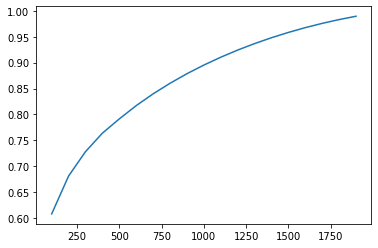

In [35]:
plt.plot(n_components_list, result)

In [37]:
pca_result.shape

(9978, 1900)

In [144]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9978 samples in 1.154s...
[t-SNE] Computed neighbors for 9978 samples in 370.708s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9978
[t-SNE] Computed conditional probabilities for sample 2000 / 9978
[t-SNE] Computed conditional probabilities for sample 3000 / 9978
[t-SNE] Computed conditional probabilities for sample 4000 / 9978
[t-SNE] Computed conditional probabilities for sample 5000 / 9978
[t-SNE] Computed conditional probabilities for sample 6000 / 9978
[t-SNE] Computed conditional probabilities for sample 7000 / 9978
[t-SNE] Computed conditional probabilities for sample 8000 / 9978
[t-SNE] Computed conditional probabilities for sample 9000 / 9978
[t-SNE] Computed conditional probabilities for sample 9978 / 9978
[t-SNE] Mean sigma: 9.992859
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.213676
[t-SNE] KL divergence after 300 iterations: 2.877037
t-SNE done! Time elapsed: 619.321489

In [145]:
df = pd.read_csv("../Train_Data.csv")
isup_grade = df["isup_grade"].to_numpy().reshape(-1,1)
isup_grade.shape
tsne_results_ = np.concatenate([tsne_results, isup_grade], axis = 1)

In [155]:
np.save("tsne_results_3cmp.npy", tsne_results)

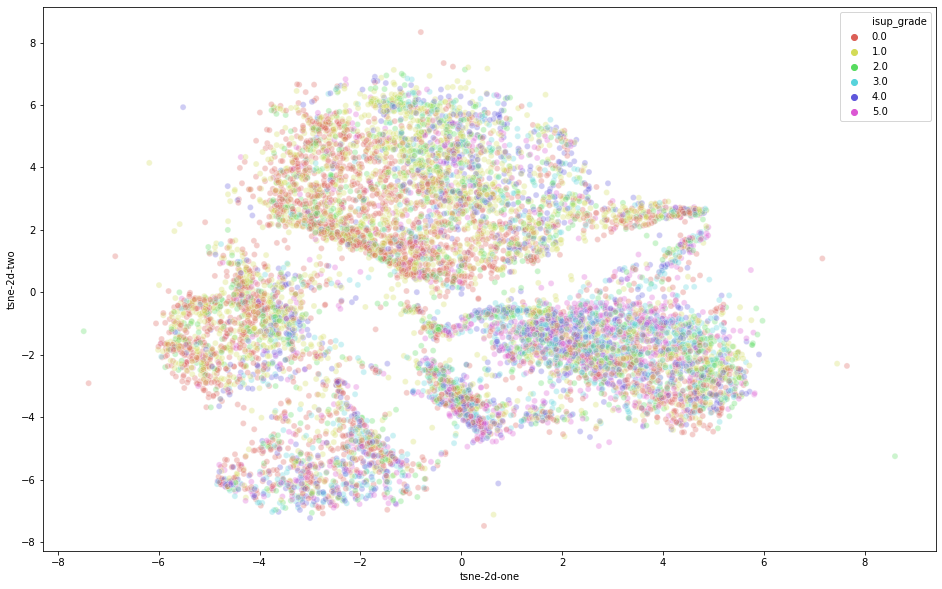

In [156]:
tsne_results_pd = pd.DataFrame(tsne_results_, columns=['tsne-2d-one', 'tsne-2d-two', 'tsne-2d-three', "isup_grade"])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="isup_grade",
    palette=sns.color_palette("hls", 6),
    data=tsne_results_pd,
    legend="full",
    alpha=0.3
)

### K-means

In [159]:
n_clusters = 12
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
k_means.fit(tsne_results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

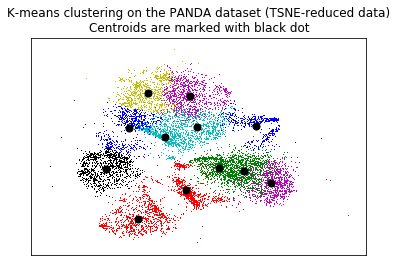

In [162]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
# x_min, x_max = tsne_results[:, 0].min() - 1, tsne_results[:, 0].max() + 1
# y_min, y_max = tsne_results[:, 1].min() - 1, tsne_results[:, 1].max() + 1
# z_min, z_max = tsne_results[:, 2].min() - 1, tsne_results[:, 2].max() + 1
# xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h),np.arange(z_min, z_max, h))

# Obtain labels for each point in mesh. Use last trained model.
# Z = k_means.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z_org = k_means.predict(tsne_results)

# Put the result into a color plot
# Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='lower')

color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(n_clusters):
    plt.plot(tsne_results[Z_org == i,0], tsne_results[Z_org == i,1], color[i%len(color)] + ',', markersize=2)

# Plot the centroids as a white X
centroids = k_means.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='o', s=50, linewidths=1,
            color='k', zorder=10)
plt.title('K-means clustering on the PANDA dataset (TSNE-reduced data)\n'
          'Centroids are marked with black dot')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [163]:
df["k_means_grp"] = Z_org
df["image_idx"] = range(len(df))
df.head()
df.to_csv("../Train_Data.csv", index = False)

Text(0.5, 1.0, 'K-means clustering on the PANDA dataset (TSNE-reduced data)')

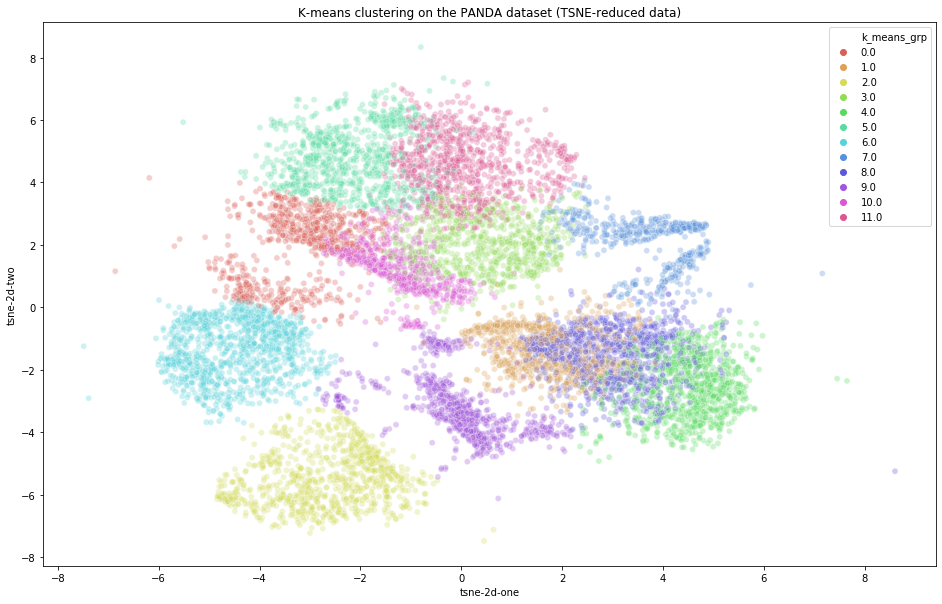

In [165]:
k_means_result_pd = pd.DataFrame(np.concatenate([tsne_results, np.asarray(Z_org).reshape(-1,1)],1),
                                 columns=['tsne-2d-one', 'tsne-2d-two', 'tsne-2d-three', "k_means_grp"])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="k_means_grp",
    palette=sns.color_palette("hls", 12),
    data=k_means_result_pd,
    legend="full",
    alpha=0.3
)
plt.title('K-means clustering on the PANDA dataset (TSNE-reduced data)')

In [127]:
tsne_results.shape, np.asarray(Z_org).reshape(-1,1).shape

((9978, 2), (9978, 1))

### DataSpecific TSNE

In [64]:
radboud_idx = df.index[df['data_provider'] == "radboud"].tolist()
radboud_feature = pca_result[radboud_idx,:]
radboud_isup = df.loc[df["data_provider"] == "radboud"]["isup_grade"].to_numpy().reshape(-1,1)

In [62]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_rad = tsne.fit_transform(radboud_feature)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4532 samples in 0.280s...
[t-SNE] Computed neighbors for 4532 samples in 70.419s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4532
[t-SNE] Computed conditional probabilities for sample 2000 / 4532
[t-SNE] Computed conditional probabilities for sample 3000 / 4532
[t-SNE] Computed conditional probabilities for sample 4000 / 4532
[t-SNE] Computed conditional probabilities for sample 4532 / 4532
[t-SNE] Mean sigma: 10.890353
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.529648
[t-SNE] KL divergence after 300 iterations: 2.509238
t-SNE done! Time elapsed: 87.85545134544373 seconds


In [66]:
tsne_results_rad_ = np.concatenate([tsne_results_rad, radboud_isup], axis = 1)

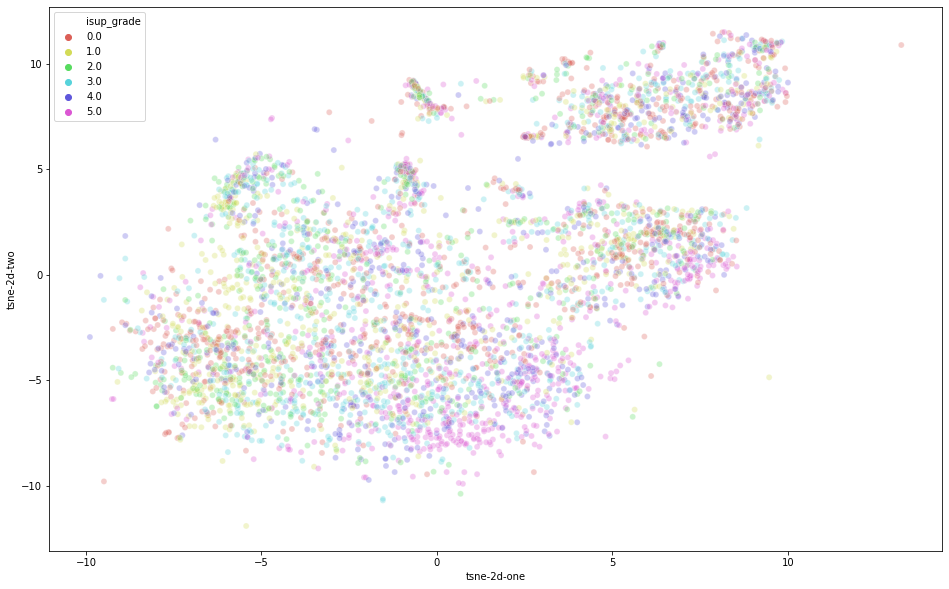

In [67]:
tsne_results_rad_pd = pd.DataFrame(tsne_results_rad_, columns=['tsne-2d-one', 'tsne-2d-two', "isup_grade"])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="isup_grade",
    palette=sns.color_palette("hls", 6),
    data=tsne_results_rad_pd,
    legend="full",
    alpha=0.3
)

In [68]:
karolinska_idx = df.index[df['data_provider'] == "karolinska"].tolist()
karolinska_feature = pca_result[karolinska_idx,:]
karolinska_isup = df.loc[df["data_provider"] == "karolinska"]["isup_grade"].to_numpy().reshape(-1,1)

In [69]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_kar = tsne.fit_transform(karolinska_feature)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5446 samples in 0.373s...
[t-SNE] Computed neighbors for 5446 samples in 105.653s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5446
[t-SNE] Computed conditional probabilities for sample 2000 / 5446
[t-SNE] Computed conditional probabilities for sample 3000 / 5446
[t-SNE] Computed conditional probabilities for sample 4000 / 5446
[t-SNE] Computed conditional probabilities for sample 5000 / 5446
[t-SNE] Computed conditional probabilities for sample 5446 / 5446
[t-SNE] Mean sigma: 9.458630
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.721863
[t-SNE] KL divergence after 300 iterations: 2.726300
t-SNE done! Time elapsed: 134.47841930389404 seconds


In [70]:
tsne_results_kar_ = np.concatenate([tsne_results_kar, karolinska_isup], axis = 1)

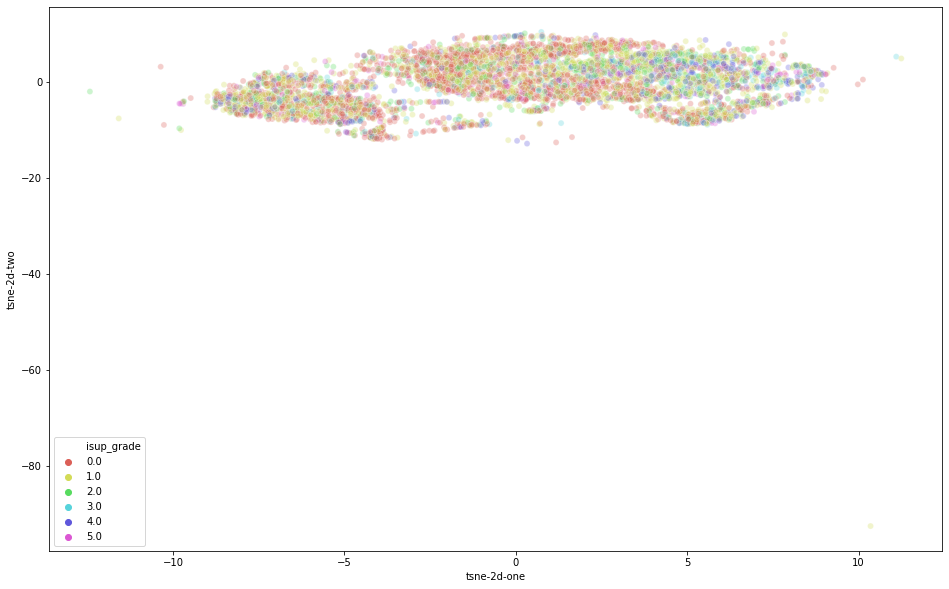

In [71]:
tsne_results_kar_pd = pd.DataFrame(tsne_results_kar_, columns=['tsne-2d-one', 'tsne-2d-two', "isup_grade"])
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="isup_grade",
    palette=sns.color_palette("hls", 6),
    data=tsne_results_kar_pd,
    legend="full",
    alpha=0.3
)